In [1]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time
start = time.time()

In [2]:
agency_path = os.path.join('RATES', 'SP500.xlsx')
agency = pd.read_excel(agency_path)
agency=agency.drop([agency.columns[0]], axis=1)
agency.loc[:, 'Rating'] = LabelEncoder().fit_transform(agency['Rating'])

In [3]:
agency.head()

,Country,Date,Rating,Flag
0,Angola,2017-08-11,9,1
1,Angola,2016-02-12,7,1
2,Angola,2015-02-13,8,1
3,Angola,2011-07-12,12,0
4,Argentina,2019-08-30,19,1


In [4]:
datas_list = os.listdir('DATA')
main_data=list()
for data in datas_list:
    df = pd.read_csv(os.path.join('DATA', data))
    name = data.split('.')[0]
    name_col = pd.Series([name] * df.shape[0], name='Страна')
    df = pd.concat([df, name_col], axis=1)
    main_data.append(df)

main_data = pd.concat(main_data, axis=0, ignore_index=True)
    

In [5]:
main_data.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Страна
0,15.11.2019,"6.758,80","6.698,50","6.762,80","6.698,50","218,50M","0,90%",Australia
1,14.11.2019,"6.698,50","6.663,30","6.705,30","6.644,20","248,13M","0,53%",Australia
2,13.11.2019,"6.663,30","6.726,10","6.737,30","6.663,30","257,79M","-0,93%",Australia
3,12.11.2019,"6.726,10","6.748,70","6.751,20","6.700,70","236,01M","-0,33%",Australia
4,11.11.2019,"6.748,70","6.699,50","6.748,70","6.688,60","224,86M","0,73%",Australia


#### data processing: converting strings into float

In [6]:
# converting percents of difference in float type
main_data.loc[:, 'Изм. %'] = main_data['Изм. %'].apply(lambda x: np.float(re.sub(r',', '.', x[:-1])))

# converting strings of Volume column into float type
def convert_vol(cell):
    try:
        cell = re.sub(r',', '.', cell)
        if cell[-1] == 'M':
            return np.float(cell[:-1])*10**6
        elif cell[-1] == 'B':
            return np.float(cell[:-1])*10**9
        elif cell[-1] == 'K':
            return np.float(cell[:-1])*10**3
        else:
            return np.nan
    except:
        return np.nan
    
main_data.loc[:, "Объём"] = main_data['Объём'].apply(convert_vol)

# covenrting date strings into datetime format
main_data.loc[:, 'Дата'] = pd.to_datetime(main_data['Дата'], format='%d.%m.%Y')

# converting other numeric strings into float type
num_cols=['Цена', 'Откр.', 'Макс.', 'Мин.']
def convert_num_strings(x):
    try:
        x = re.sub(r'\.', '', x)
        x = re.sub(r',', '.', x)
        return np.float(x)
    except:
        return x
        
for col in num_cols:
    main_data.loc[:, col] = main_data[col].apply(convert_num_strings)

In [7]:
main_data.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Страна
0,2019-11-15,6758.8,6698.5,6762.8,6698.5,218500000.0,0.90,Australia
1,2019-11-14,6698.5,6663.3,6705.3,6644.2,248130000.0,0.53,Australia
2,2019-11-13,6663.3,6726.1,6737.3,6663.3,257790000.0,-0.93,Australia
3,2019-11-12,6726.1,6748.7,6751.2,6700.7,236010000.0,-0.33,Australia
4,2019-11-11,6748.7,6699.5,6748.7,6688.6,224860000.0,0.73,Australia


#### adding to main dataframe rating column

In [8]:
# countries's ratings change
country_events={}
for country in agency['Country'].unique():
    events = agency[agency['Flag'] != 0][agency['Country'] == country]
    country_events.update({country:events[['Date', 'Rating']]})

In [9]:
%%time
missing_countries=[]
def add_rate(row):
    try:
        country=row['Страна']
        rates = country_events[country]
        rates = rates.sort_values('Date', ascending=False)
        rates = rates[rates['Date'] <= row['Дата']]
        if rates.shape[0] != 0:
            rate = rates.iloc[0, 1]
        else:
            rate = agency.sort_values('Date', ascending=True)[agency['Country'] == country].iloc[0, 2]
    except Exception as e:
        missing_countries.append(country)
        rate = np.nan
    return rate    

main_data['Оценки'] = pd.Series(np.zeros(main_data.shape[0]))
main_data['Оценки'] = main_data.apply(add_rate, axis=1)

pd.Series(missing_countries).unique()

Wall time: 3min 46s


array([], dtype=float64)

In [10]:
main_data.tail()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Страна,Оценки
96288,2000-10-23,16277.84,16841.92,16841.92,16169.28,NaN,-3.35,Turkey,15
96289,2000-10-20,16841.92,16825.83,17524.80,16635.84,NaN,0.10,Turkey,15
96290,2000-10-19,16825.83,16791.01,17080.30,16676.68,NaN,0.21,Turkey,15
96291,2000-10-18,16791.01,17145.09,17283.49,16623.25,NaN,-2.07,Turkey,15
96292,2000-10-17,17145.09,17377.24,17394.83,16830.20,NaN,-1.34,Turkey,15


In [11]:
for country in main_data['Страна'].unique():
    print('{0} shape: {1} missed: {2}'.format(country, main_data[main_data["Страна"] == country].shape[0], main_data[main_data["Объём"].isna()].shape[0]))

Australia shape: 4797 missed: 34002
Austria shape: 1160 missed: 34002
Bahrain shape: 2352 missed: 34002
Belgium shape: 4883 missed: 34002
Brazil shape: 4706 missed: 34002
China shape: 1209 missed: 34002
Egypt shape: 4662 missed: 34002
Finland shape: 4686 missed: 34002
France shape: 4882 missed: 34002
Greece shape: 1491 missed: 34002
Hong Kong shape: 4697 missed: 34002
Hungary shape: 2037 missed: 34002
India shape: 4744 missed: 34002
Indonesia shape: 4656 missed: 34002
Italy shape: 4219 missed: 34002
Japan shape: 4651 missed: 34002
Kazakhstan shape: 1277 missed: 34002
Philippines shape: 1957 missed: 34002
Portugal shape: 2432 missed: 34002
Russia shape: 4673 missed: 34002
Saudi Arabia shape: 5000 missed: 34002
South Africa shape: 4777 missed: 34002
South Korea shape: 1995 missed: 34002
Spain shape: 4850 missed: 34002
Tunisia shape: 4714 missed: 34002
Turkey shape: 4786 missed: 34002


In [12]:
main_data.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Страна,Оценки
0,2019-11-15,6758.8,6698.5,6762.8,6698.5,218500000.0,0.90,Australia,6
1,2019-11-14,6698.5,6663.3,6705.3,6644.2,248130000.0,0.53,Australia,6
2,2019-11-13,6663.3,6726.1,6737.3,6663.3,257790000.0,-0.93,Australia,6
3,2019-11-12,6726.1,6748.7,6751.2,6700.7,236010000.0,-0.33,Australia,6
4,2019-11-11,6748.7,6699.5,6748.7,6688.6,224860000.0,0.73,Australia,6


#### checking for nan values in Volume column

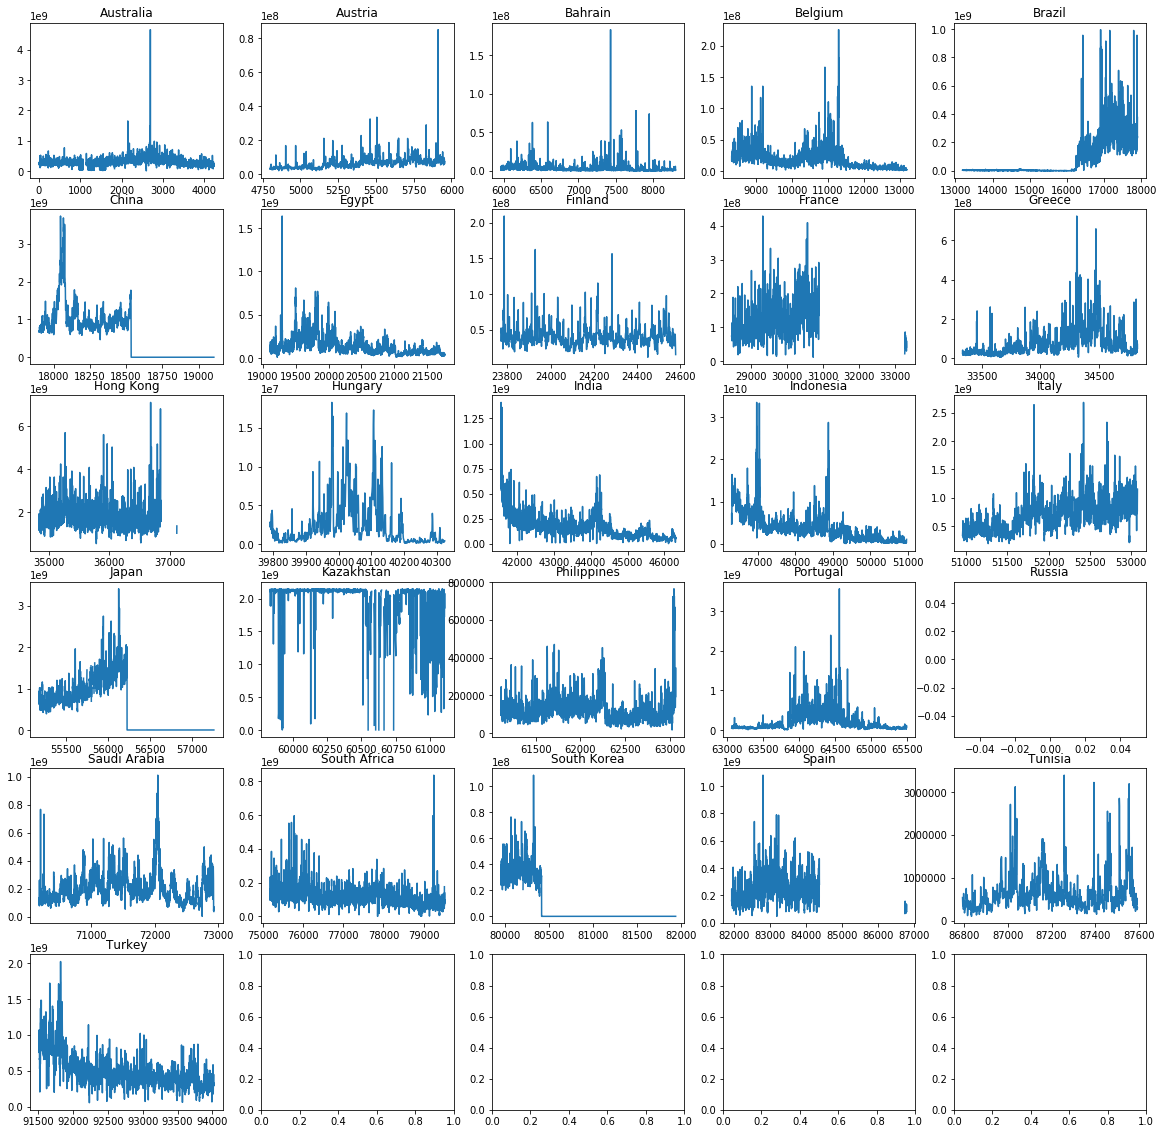

In [13]:
fig, axes = plt.subplots(6,5, figsize=(20,20))
for ax, col in zip(axes.ravel(), main_data['Страна'].unique()):
    ax.plot(main_data[main_data['Страна'] == col]['Объём'])
    ax.set_title(col)
    
plt.show()

In [14]:
main_data = main_data.fillna(method='ffill', limit=4)
main_data = main_data.dropna(how='any')
main_data.shape

(62678, 9)

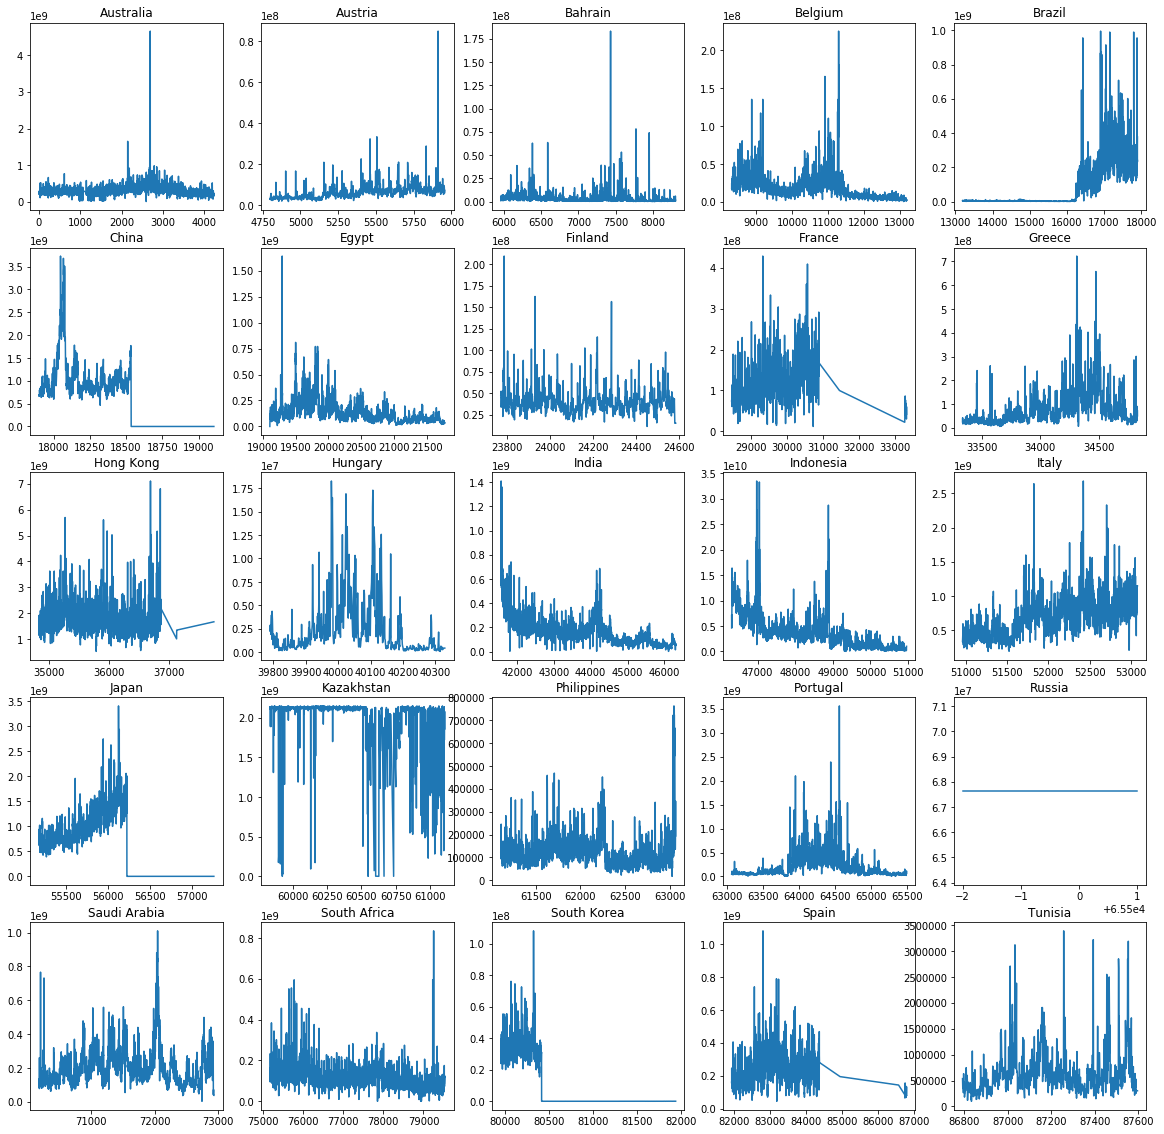

In [15]:
fig, axes = plt.subplots(5,5, figsize=(20,20))
for ax, col in zip(axes.ravel(), main_data['Страна'].unique()):
    ax.plot(main_data[main_data['Страна'] == col]['Объём'])
    ax.set_title(col)
    
plt.show()

In [16]:
rus_indices = main_data[main_data['Страна'] == 'Russia'].index
main_data = main_data.drop(labels=rus_indices, axis=0)

#### drop unnecessary columns

In [17]:
cols_to_save=['Дата', "Объём", "Оценки", 'Страна']
main_data = main_data[cols_to_save]
main_data.head()

,Дата,Объём,Оценки,Страна
0,2019-11-15,218500000.0,6,Australia
1,2019-11-14,248130000.0,6,Australia
2,2019-11-13,257790000.0,6,Australia
3,2019-11-12,236010000.0,6,Australia
4,2019-11-11,224860000.0,6,Australia


In [18]:
data_copy = main_data.copy()

main_data['Year'] = main_data.apply(lambda x: x['Дата'].year, axis=1)
main_data['Month'] = main_data.apply(lambda x: x['Дата'].month, axis=1)
main_data['Day'] = main_data.apply(lambda x: x['Дата'].day, axis=1)

main_data = main_data.drop(columns=['Дата'], axis=1)
country_le = LabelEncoder().fit(main_data['Страна'])
main_data.loc[:, 'Страна'] = country_le.transform(main_data['Страна'])


In [19]:
main_data.loc[:, 'Страна'] = LabelEncoder().fit_transform(main_data['Страна'])

In [20]:
available_countries = main_data['Страна'].unique()
for col in main_data.columns[2:]:
    dumm = pd.get_dummies(main_data[col], prefix=col, prefix_sep='#')
    try:
        main_data = pd.concat([main_data, dumm], axis=1)
    except Exception as e:
        print(f'Problem in {col}')
    else:
        main_data = main_data.drop(columns=[col], axis=1)
    

In [21]:
main_data.head(10)

,Объём,Оценки,Страна#0,Страна#1,Страна#2,Страна#3,Страна#4,Страна#5,Страна#6,Страна#7,...,Day#22,Day#23,Day#24,Day#25,Day#26,Day#27,Day#28,Day#29,Day#30,Day#31
0,218500000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,248130000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,257790000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,236010000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,224860000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,260950000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,285060000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,293020000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,220690000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,214780000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


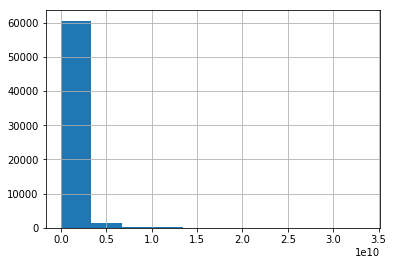

In [22]:
main_data['Объём'].hist()

In [23]:
%%time
def scale_values(X):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    X_std = (X - X_min) / (X_max - X_min)
    X_scaled = X_std * (1 - 0) + 0
    return X_scaled, X_max, X_min
    
target_scaled, max_v, min_v = scale_values(main_data['Объём'])
    
X_train, X_test, y_train, y_test = train_test_split(main_data.drop(columns=['Объём']), target_scaled, random_state=40)

# default parameters
model = RFR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
error = mean_squared_error(y_pred, y_test)
print(error)

0.00017395942472831307
Wall time: 3.65 s


In [24]:
main_data.head()

,Объём,Оценки,Страна#0,Страна#1,Страна#2,Страна#3,Страна#4,Страна#5,Страна#6,Страна#7,...,Day#22,Day#23,Day#24,Day#25,Day#26,Day#27,Day#28,Day#29,Day#30,Day#31
0,218500000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,248130000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,257790000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,236010000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,224860000.0,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
def make_plot(c, y_pred_single_var, y_true_var, events_lines, max_w, min_w, w_err, a_counter):
#     plt.figure(figsize=(20,20))
#     plt.figure()
    plt.figure(figsize=(10,10))
    y_pred_single_var = y_pred_single_var*(max_w-min_w)+min_w
    y_true_var = y_true_var*(max_w-min_w)+min_w
    plt.plot(y_true_var, linewidth=0.75, alpha=0.6, label='True values')
    plt.plot(y_pred_single_var, linewidth=1.4, alpha=0.6, label='Predicted values')
    for event in events_lines:
#         plt.axvline(x=event[0], c=event[1], linewidth=0.9, label=str(event[0]))
        plt.axvline(x=event[0], c=event[1], linewidth=0.9)
    plt.title(f'{c} (MSE: {round(w_err,4)}, anomalies: {a_counter})')
    plt.legend()
    plt.grid()
   
    
def find_event_index_to_plot(X_country, y,m,d, deep=0):
    row = X_country[X_country['Year#'+str(y)] == 1]
    row = row[row['Month#'+str(m)] == 1]
    row = row[row['Day#'+str(d)] == 1]
    try:
        res = row.index[0]
    except IndexError:
        if deep != 10:
            if d < 31:
                res = find_event_index_to_plot(X_country,y,m,d+1, deep+1)
            elif d >= 31 and m < 12:
                res = find_event_index_to_plot(X_country,y,m+1,1, deep+1)
            elif d>=31 and m >= 12:
                res = find_event_index_to_plot(X_country,y+1,1,1, deep+1)
            else:
                res = 0
        else:
            res=0
    return res

# def find_anomaly_points(df, index, err):
#     window = df.iloc[index:index+5,:]
#     anomalies = window.iloc[:,2].apply(lambda x: 1 if x>err*0.00005 else 0)
#     return anomalies
    
    
def evaluate_model(c_num, model, max_w, min_w):
    # constructing plot
    c_str = country_le.inverse_transform([c_num])[0]
    X_draw = main_data[main_data['Страна#'+str(c_num)]==1]
    X_draw = X_draw.reset_index(drop=True)
    y_pred_single = model.predict(X_draw.drop(columns=['Объём'], axis=1))
    y_true,max_w,min_w = scale_values(X_draw['Объём'])
    
    # whole error
    y_true = pd.Series(y_true)
    y_pred_single = pd.Series(y_pred_single)
    whole_error = mean_squared_error(y_true, y_pred_single)
    
    # detecting anomalies
    anomaly_df = pd.DataFrame()
    anomaly_df = pd.concat([anomaly_df, y_pred_single, y_true], axis=1)
    anomaly_df['diff'] = np.absolute(anomaly_df.iloc[:,0] - anomaly_df.iloc[:,1])
    #anomaly_df['diff'] = anomaly_df['diff'].apply(lambda x: 1 if x > whole_error else 0)
    
    # summary error
    events = list(country_events[c_str].iloc[:,0])
    sum_event_error=0
    events_lines=[]
    event_counter=0
    anomaly_counter=0
    for event in events:
        Y = event.year
        M = event.month
        D = event.day
        try:
            row = main_data[main_data['Year#'+str(Y)] == 1]
            row = row[row['Month#'+str(M)] == 1]
            row = row[row['Day#'+str(D)] == 1]
        except KeyError:
            print(Y, 'is not exist in training dataset', 'while training', c_str)
            continue
        try:# event_index индекс для изъятия 
            event_index = row.index[0]
        except IndexError:
            print('No data at time', Y, M, D, 'while training', c_str)
            continue
        d = data_copy.copy()
        d = d.iloc[event_index:event_index+5, :]
        indices = d.index
        
        event_index = find_event_index_to_plot(X_draw, Y,M,D)        
        
#         anomaly_points = find_anomaly_points(anomaly_df, event_index, whole_error)
        
        window = anomaly_df.iloc[event_index:event_index+5,:]
        anomaly_points = window.iloc[:,2].apply(lambda x: 1 if x>whole_error*0.00005 else 0)

        anomaly_values = anomaly_df.iloc[anomaly_points.index, 1]
        anomaly_values = anomaly_values*(max_w-min_w)+min_w
        anomaly_values = anomaly_values*anomaly_points
#         anomalies.append(anomaly_values)
        
        event_data = main_data.reset_index().iloc[indices, :]
        y_true_event, t1, t2 = scale_values(event_data['Объём'])
        Xx = event_data.drop(columns=['Объём'], axis=1)
        Xx = Xx.iloc[:,1:]
        try:
            y_pred_event = model.predict(Xx)
        except ValueError:
            print('Empty dataframe is attempted to fit model', 'while training', c_str)
            continue
        err = abs(mean_squared_error(y_true_event, y_pred_event))
        anomaly = 'red' if err/100 > whole_error else 'green'
        anomaly_counter = anomaly_counter+1 if err/100 > whole_error else anomaly_counter
        events_lines.append((event_index, anomaly))
        sum_event_error += err
        event_counter +=1 
    
    try:
        avg_event_error = sum_event_error / event_counter
        avg_event_error /= 100
    except:
        avg_event_error = np.nan
    # drawing plot
    make_plot(c_str, anomaly_df.iloc[:,0], anomaly_df.iloc[:,1], events_lines, max_w, min_w, whole_error, anomaly_counter)
    
    
    # difference between errors
    errors_diff = abs(whole_error-sum_event_error)
    
    # saving results
    # поменять названия на английский
    columns = ["Country", 'Average model error, %', 'Average event window error, %', 'Number of anomalies', 'Number of events']
    data = [[c_str, whole_error*100, avg_event_error*100, anomaly_counter, len(events)]]
    model_review = pd.DataFrame(data=data, columns=columns)
#     table.to_excel(os.path.join('save_files', c_str+'.xlsx'))
#     plt.savefig(os.path.join('save_files', c_str+'.png'))
    return model_review

# if not os.path.exists('save_files'):
#     os.mkdir(os.path.join(os.getcwd(), 'save_files'))
    


#### separate fitting

Wall time: 5.13 s


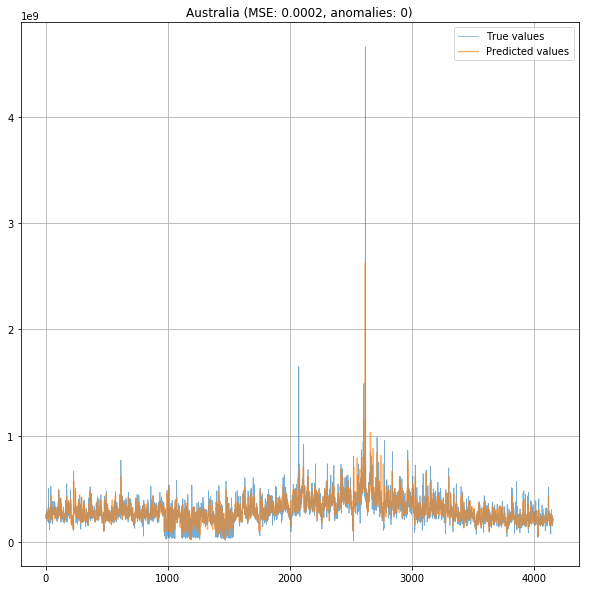

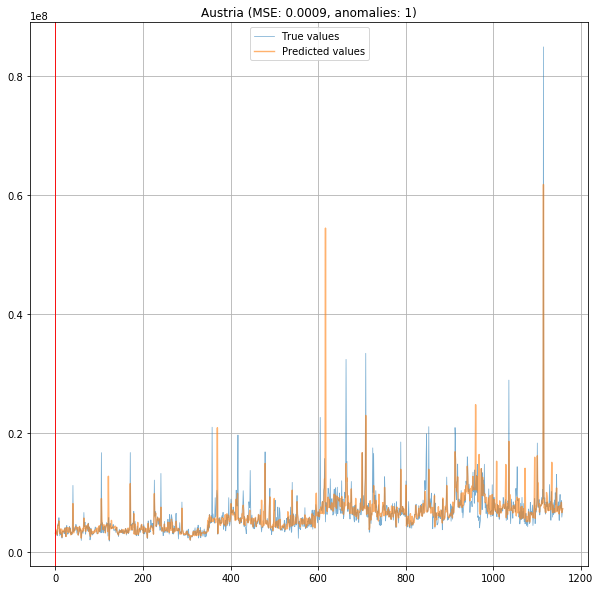

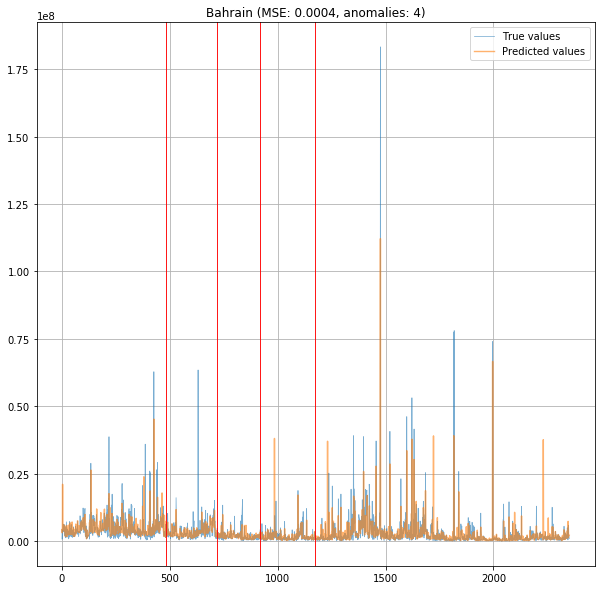

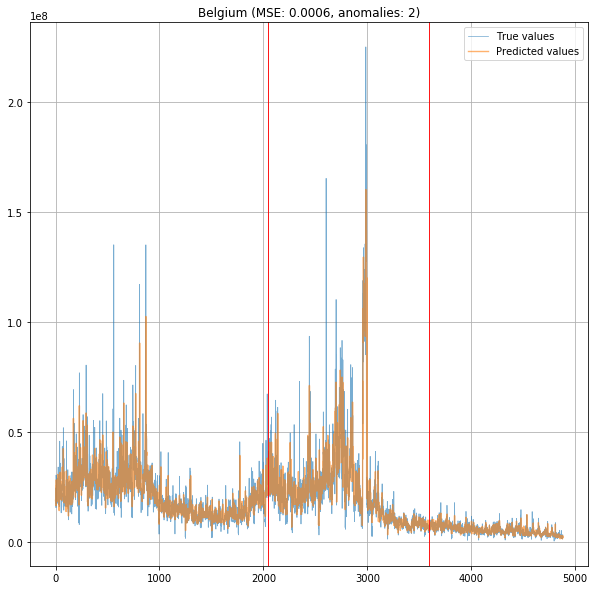

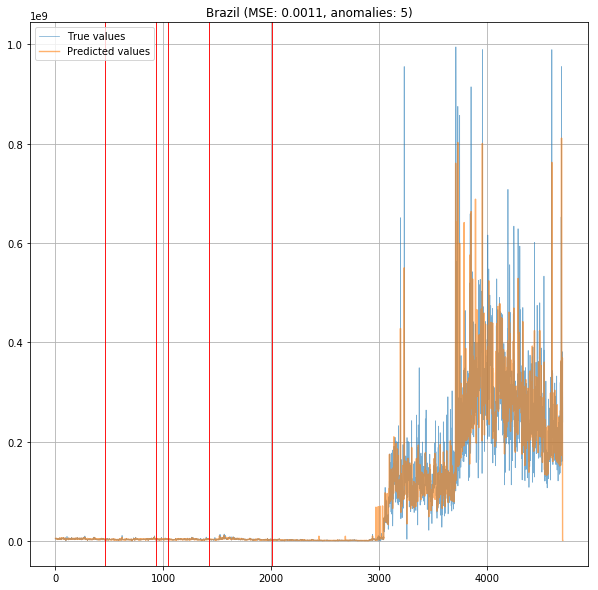

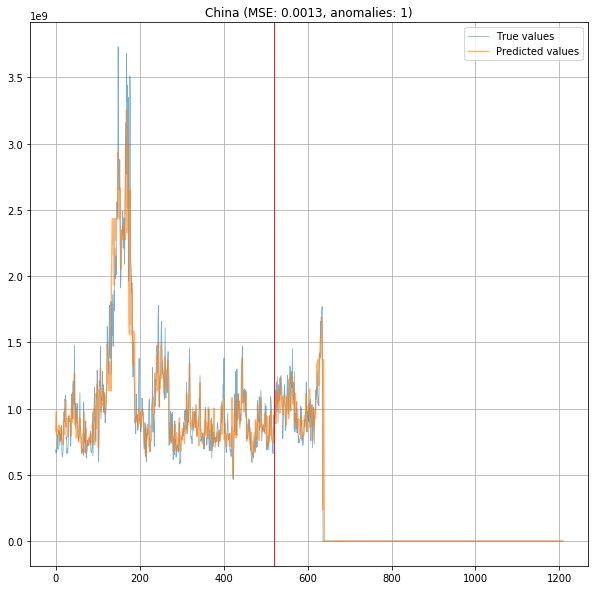

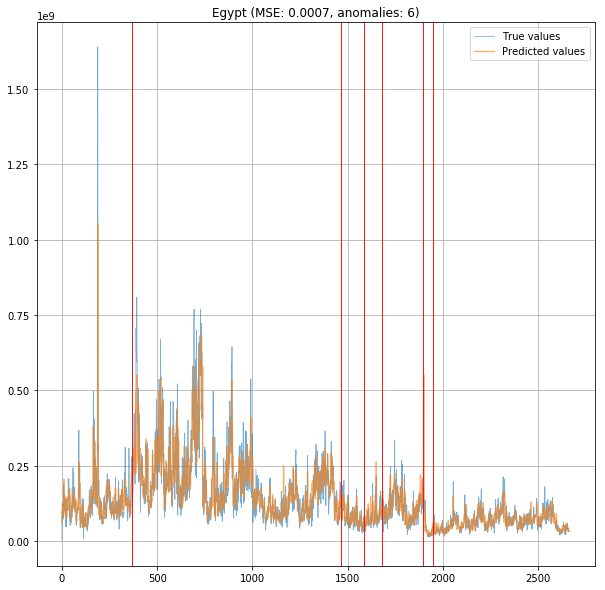

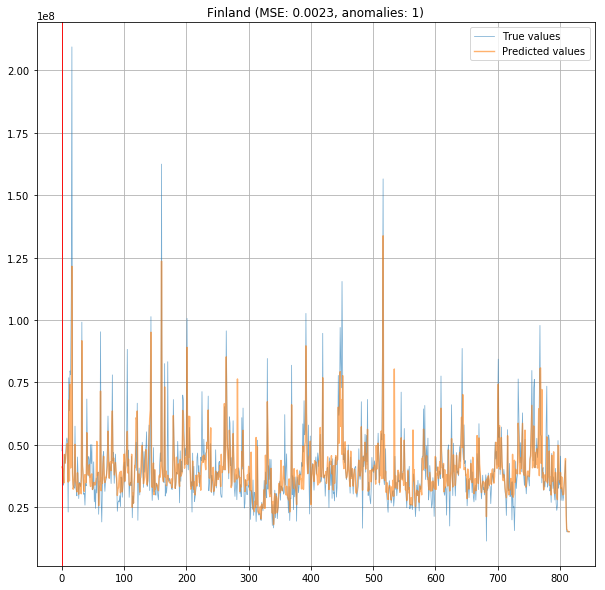

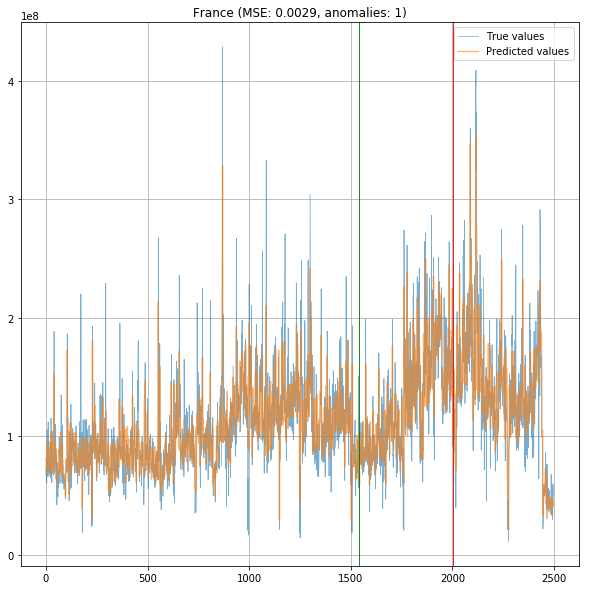

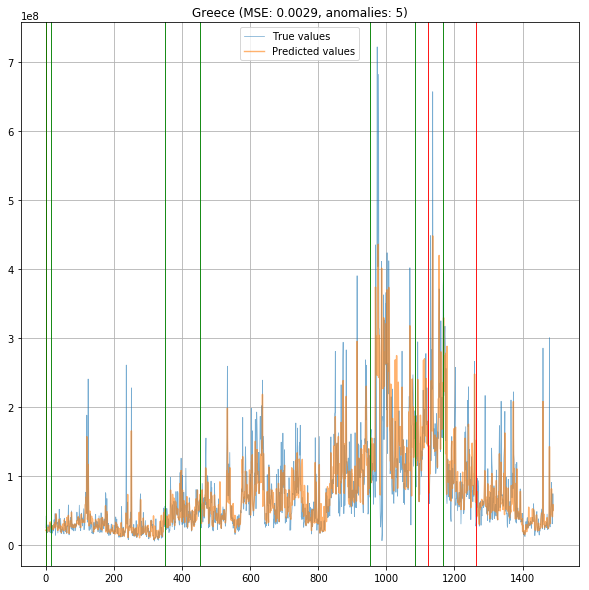

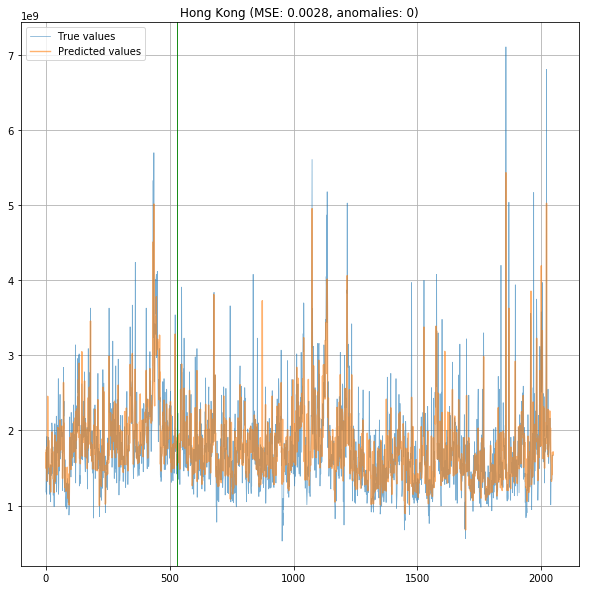

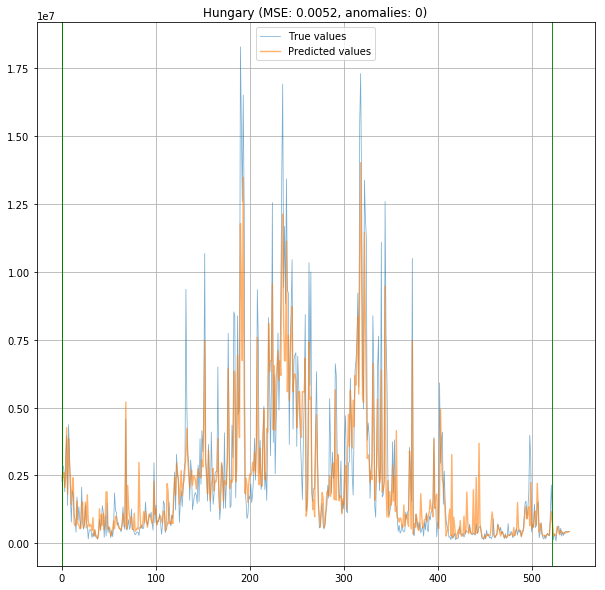

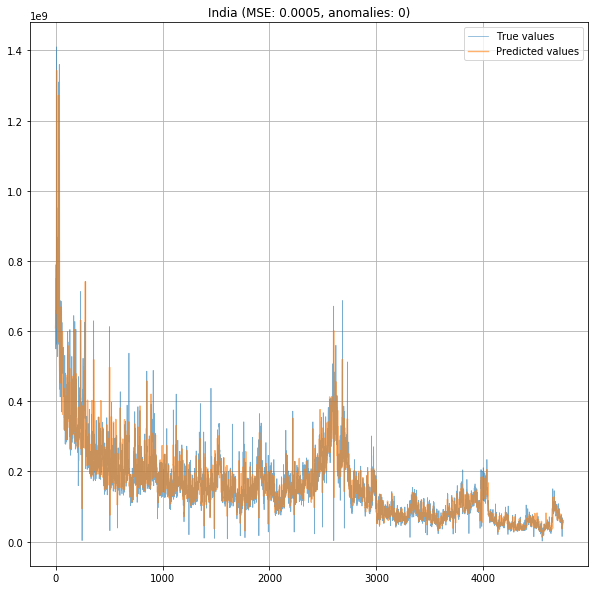

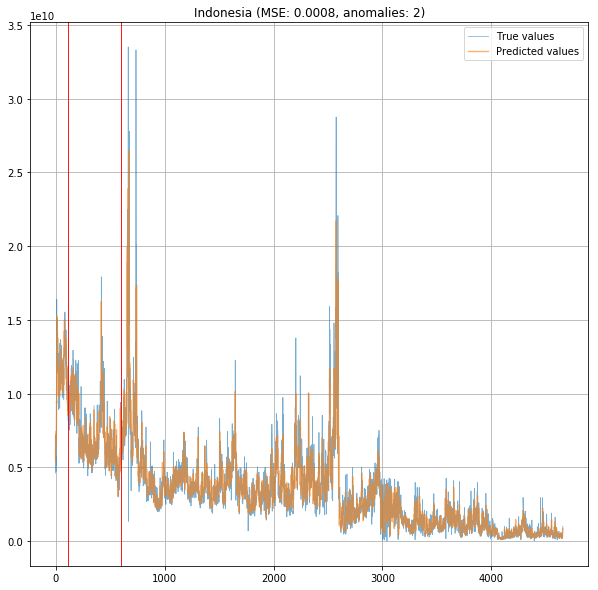

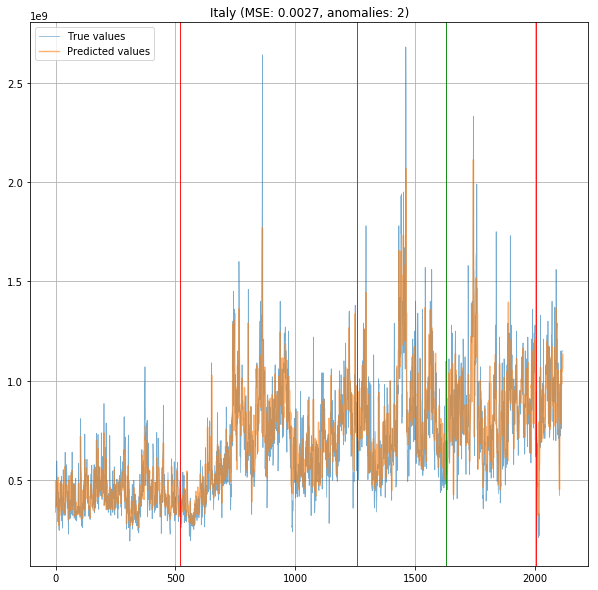

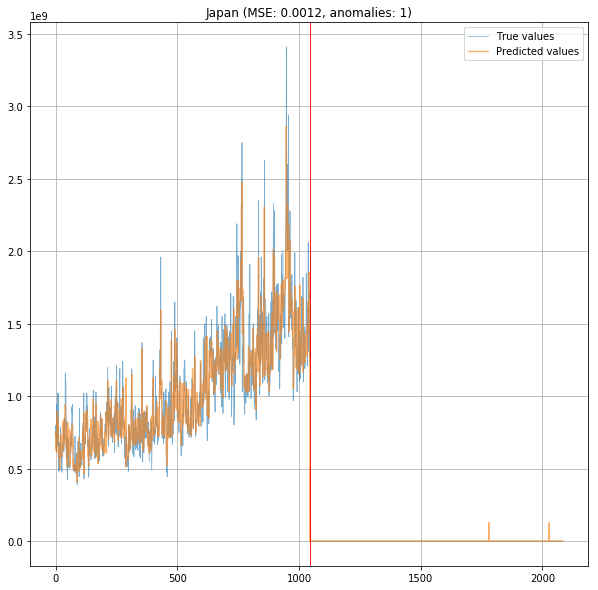

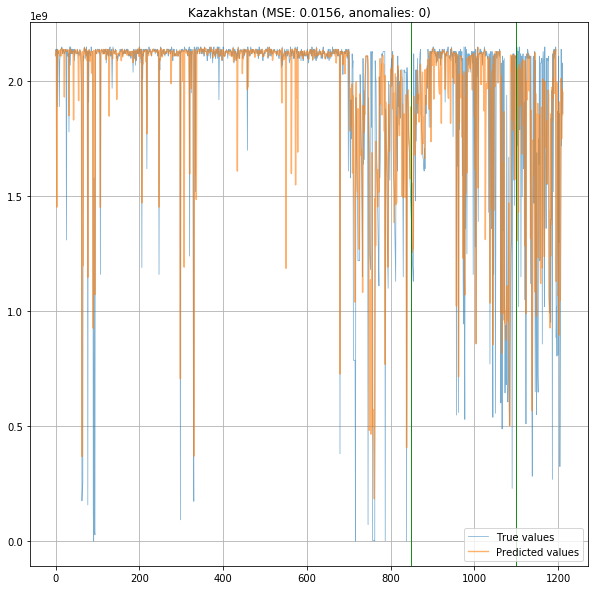

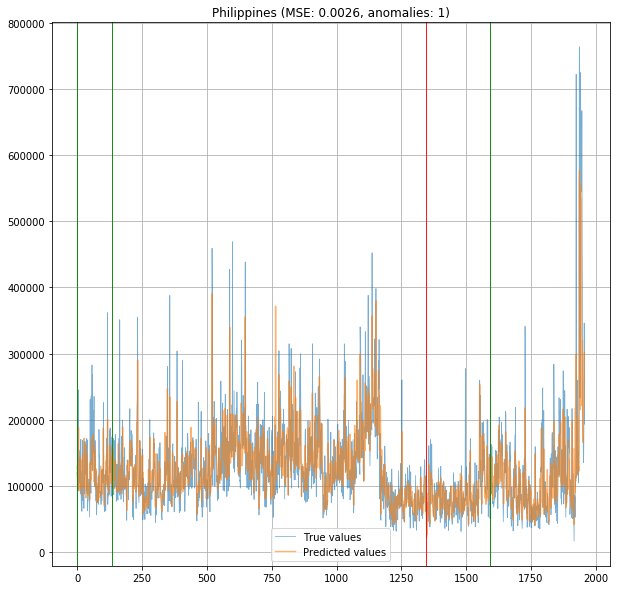

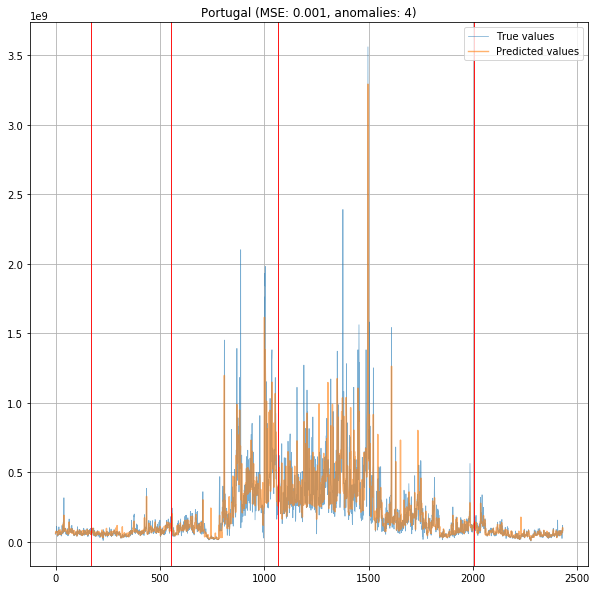

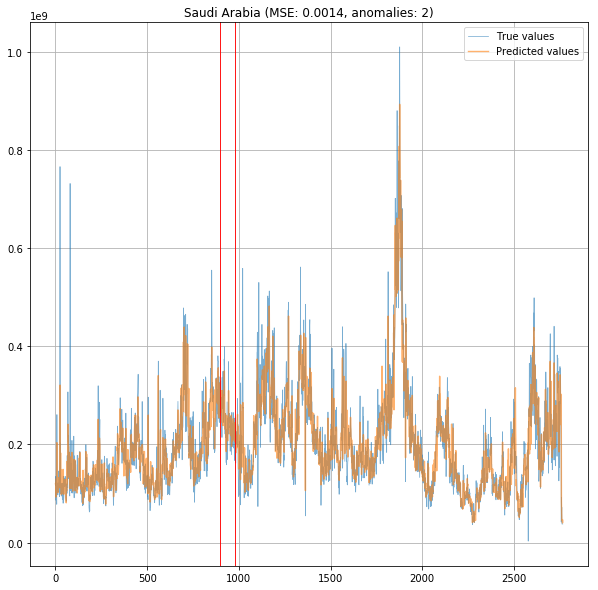

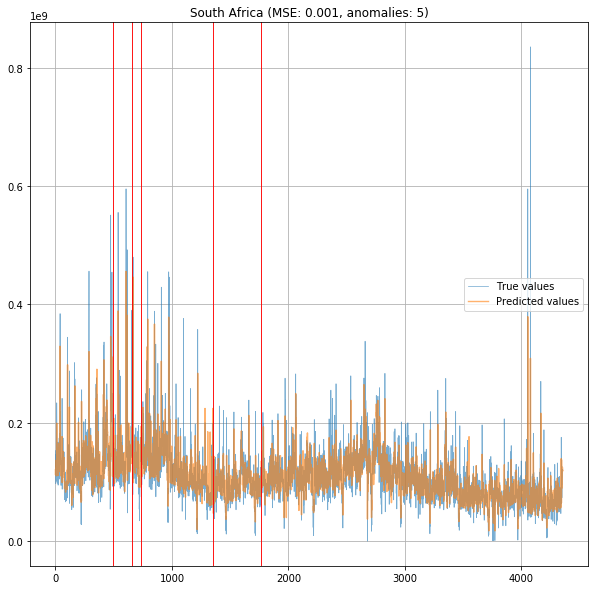

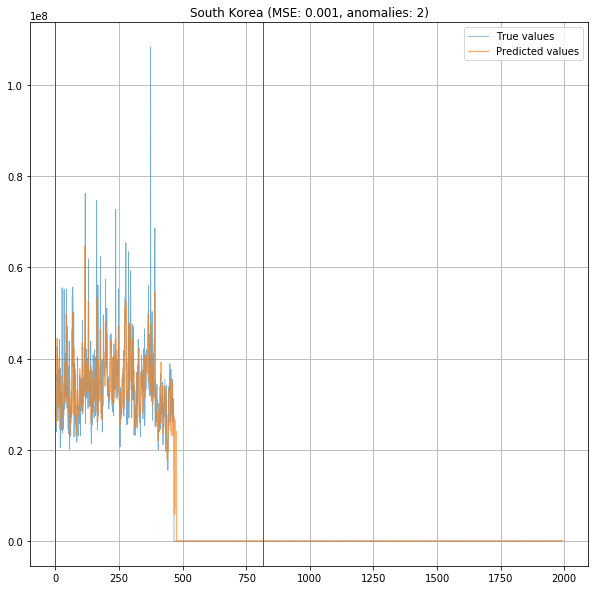

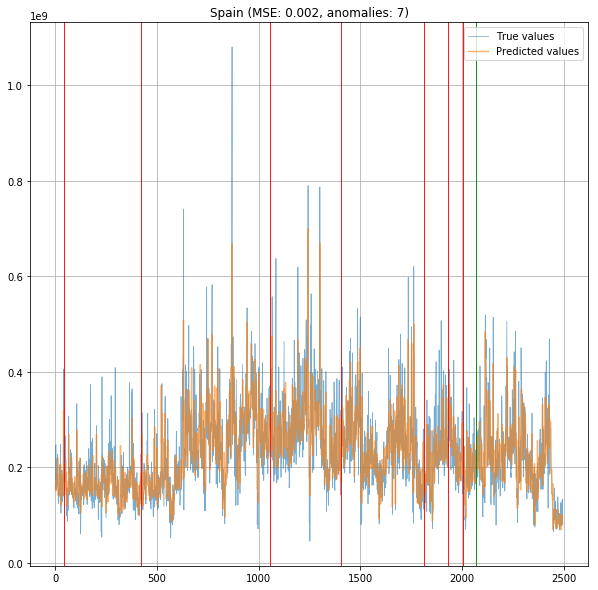

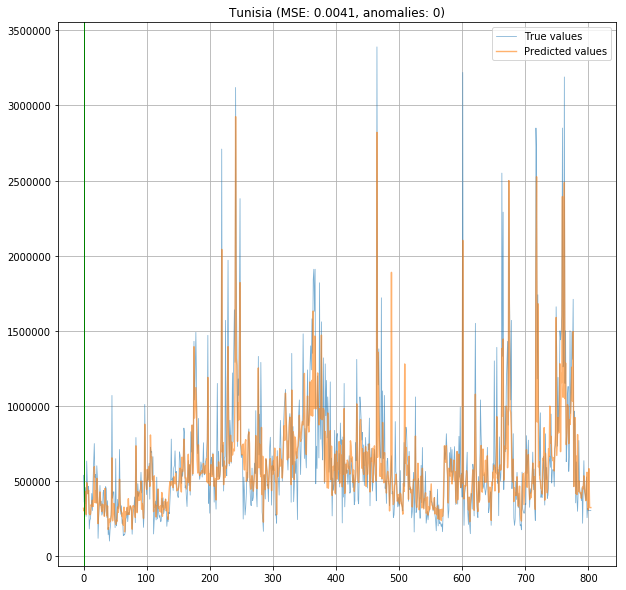

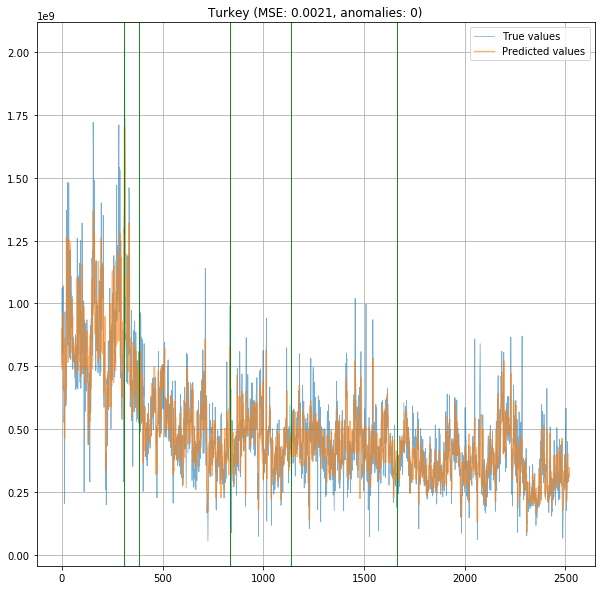

In [26]:
%%time
main_table=pd.DataFrame()
for c_num in available_countries:
    dd = main_data[main_data['Страна#'+str(c_num)] == 1]
    X_part = dd.drop(columns=['Объём'], axis=1)
    y_part, max_v, min_v = scale_values(dd['Объём'])
    X_train, X_test, y_train, y_test = train_test_split(X_part, y_part, random_state=40)
    model = RFR().fit(X_train, y_train)
    res = evaluate_model(c_num, model, max_v, min_v)
    main_table = pd.concat([main_table, res], axis=0, ignore_index=True)

In [27]:
main_table

,Country,"Average model error, %","Average event window error, %",Number of anomalies,Number of events
0,Australia,0.022228,NaN,0,0
1,Austria,0.087522,0.528792,1,1
2,Bahrain,0.044938,0.371436,4,4
3,Belgium,0.062018,0.238845,2,2
4,Brazil,0.109516,0.416135,5,5
5,China,0.127216,0.220822,1,1
6,Egypt,0.070681,0.300587,6,6
7,Finland,0.227060,0.338118,1,1
8,France,0.287233,0.276662,1,2
9,Greece,0.287933,0.262692,5,14


In [28]:
print(time.time() - start, 'secs')

256.6686055660248 secs
